# Using Python for Data Analysis

## Fundamental usage of Python

We'll need to understand some very basic Python in order to do this tutorial.

In [1]:
'Hello World'  # Change the letters and press on your keyboard control + Enter

'Hello World'

In [2]:
'你好世界'  # Or press the ▶️Run button above

'你好世界'

#### Assigning variables to values

You can store variables for re-use. You've hopefully seen this in other programming languages:

In [3]:
# You can assign values to variables
a = 1
print('Print a single number:')
print(a)
print('Arithmetic operations, too:')
print(a + a)

Print a single number:
1
Arithmetic operations, too:
2


#### Quick review of types

A few types we'll focus on:
- `Booleans`, which indicate whether something is true or false
- `Strings`, which represent a group of characters, like `'hey'`
- Whole numbers like `7` or `101` (called *integers*) and fractions like `7.3` and `3.41` (called here *floats*)

In [4]:
b = 'Hello everyone'
c = '大家好'
print(b)
print(c)

Hello everyone
大家好


In [5]:
'大' in '大家好'

True

In [6]:
b.lower()

'hello everyone'

In [7]:
b[0]  # Get the first letter of string, note that 0 indicates the  first

'H'

In [8]:
b[6:] # Get the seventh character until the end

'everyone'

## Pandas Overview

Pandas is a widely-used library for data analyis. We'll be using a small subset of its features for this talk.

First, execute the next cell to load up the `pandas` and `seaborn` libraries.

In [9]:
# If you're running this "locally" (on your computer, outside of this lecture and not on Binder),
# you will need to install these libraries
import pandas as pd
import seaborn as sns

In [59]:
# Loading in a CSV
# Read a file from a URL
AIR_TRAFFIC_URL = 'https://raw.githubusercontent.com/ajduberstein/sf_public_data/master/Air_Traffic_Passenger_Statistics.csv'
FLOOD_DATA_URL = 'https://raw.githubusercontent.com/ajduberstein/dartmouth_flood_data/master/floods.csv'
floods = pd.read_csv(FLOOD_DATA_URL)
sfo = pd.read_csv(AIR_TRAFFIC_URL)
# Read a file from your local file system
floods_over_time = pd.read_csv('./floods_by_cause_by_year.csv')

In [11]:
# See the first 5 rows
floods.head()

,id,lng,lat,area,began,ended,validation,dead,displaced,main_cause,severity
0,1,5.23026,35.81420,92615.67,1/1/85,1/5/85,News,26,3000,Heavy rain,1.0
1,2,-45.34890,-18.71110,678498.80,1/15/85,2/2/85,News,229,80000,Heavy rain,2.0
2,3,122.97400,10.02070,12846.03,1/20/85,1/21/85,News,43,444,Torrential rain,1.0
3,4,124.60600,1.01489,16542.12,2/4/85,2/18/85,News,21,300,Torrential rain,1.0
4,5,32.34910,-25.86930,20082.21,2/9/85,2/11/85,News,19,0,Heavy rain,2.0


In [12]:
# See the last 5 rows in any data set
floods.tail()

,id,lng,lat,area,began,ended,validation,dead,displaced,main_cause,severity
4792,4795,105.4790,14.5905,146786.00,9/5/19,9/14/19,FloodList,7,50000,Heavy Rain,1.5
4793,4796,-1.0908,38.0496,9114.70,9/12/19,9/14/19,FloodList,3,300,Torrential Rain,1.5
4794,4797,-95.4473,29.4687,33023.95,9/19/19,9/22/19,FloodList,6,0,Tropical Storm Imelda,2.0
4795,4798,74.3521,25.3928,180234.00,9/13/19,9/22/19,FloodList,0,4500,Monsoonal Rain,1.5
4796,4799,77.3956,24.1511,236728.10,9/15/19,9/22/19,FloodList,0,45000,Monsoonal Rain,1.5


In [13]:
# Get summary statistics
floods.describe()

,id,lng,lat,area,dead,displaced,severity
count,4797.000000,4797.000000,4797.000000,4.797000e+03,4797.000000,4.797000e+03,4797.000000
mean,2399.786950,34.725954,18.208693,1.060645e+05,140.426517,1.361169e+05,1.229310
std,1385.693343,79.546440,22.987267,2.206553e+05,3403.104802,1.188938e+06,0.376061
min,1.000000,-173.454000,-52.907600,1.195650e+01,0.000000,0.000000e+00,1.000000
25%,1200.000000,-16.967700,5.273370,9.471480e+03,0.000000,0.000000e+00,1.000000
50%,2400.000000,42.489900,21.657700,3.385649e+04,5.000000,1.200000e+03,1.000000
75%,3600.000000,104.168000,35.916100,1.055833e+05,22.000000,1.600000e+04,1.500000
max,4799.000000,179.651000,68.159100,4.814281e+06,160000.000000,4.000000e+07,2.000000


In [14]:
# See the names of all the columns
floods.columns

Index(['id', 'lng', 'lat', 'area', 'began', 'ended', 'validation', 'dead',
       'displaced', 'main_cause', 'severity'],
      dtype='object')

In [15]:
# Select a single colmn
floods['area']

0        92615.67
1       678498.80
2        12846.03
3        16542.12
4        20082.21
          ...    
4792    146786.00
4793      9114.70
4794     33023.95
4795    180234.00
4796    236728.10
Name: area, Length: 4797, dtype: float64

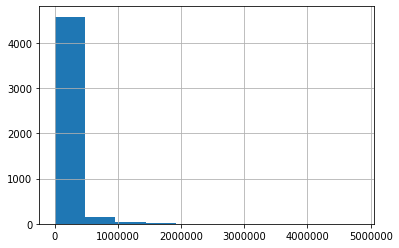

In [16]:
# Get a histogram for a single column
floods['area'].hist()

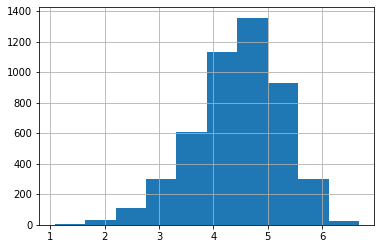

In [17]:
# You're also in Python, so you can call in other Python functions
import math
# Apply a log scale to the histogram

# In case logs are murky:
# This is essentially counting the number of digits - 1
# math.log10(100) == 2
# math.log10(1000) == 3
# etc

floods['area'].apply(math.log10).hist()

In [18]:
# Aggregation
floods.count()

id            4797
lng           4797
lat           4797
area          4797
began         4797
ended         4797
validation    4797
dead          4797
displaced     4797
main_cause    4794
severity      4797
dtype: int64

In [68]:
# Your turn! How many rows are in the SFO data?

In [19]:
# Aggregate by group
floods.groupby('main_cause').count().head()

,id,lng,lat,area,began,ended,validation,dead,displaced,severity
main_cause,,,,,,,,,,
0,11,11,11,11,11,11,11,11,11,11
Avalance Breach,1,1,1,1,1,1,1,1,1,1
Avalanche related,2,2,2,2,2,2,2,2,2,2
Brief Torrential Rain,3,3,3,3,3,3,3,3,3,3
Brief torrential rain,206,206,206,206,206,206,206,206,206,206


In [20]:
# Sorting and chaining functions - this would give us the top 10 causes of floods by frequency
grouped_floods = floods.groupby('main_cause').count()
grouped_floods.sort_values('id', ascending=False).head()

,id,lng,lat,area,began,ended,validation,dead,displaced,severity
main_cause,,,,,,,,,,
Heavy rain,2130,2130,2130,2130,2130,2130,2130,2130,2130,2130
Heavy Rain,714,714,714,714,714,714,714,714,714,714
Torrential Rain,366,366,366,366,366,366,366,366,366,366
Tropical cyclone,292,292,292,292,292,292,292,292,292,292
Monsoonal rain,260,260,260,260,260,260,260,260,260,260


In [21]:
# Your turn: Plot the data in an ascending order
# grouped_floods.sort_values('id', ascending=True).head()

In [22]:
# This will be easier to plot
import math

def safe_log10(num):
    if num >= 1:
        return math.log10(num)
    return num

floods['log10_displaced'] = floods['displaced'].apply(safe_log10)

## Charts

### relplots

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(24.7, 8.6)})
plt.figure(figsize=(45,10))

<Figure size 3240x720 with 0 Axes>

<Figure size 3240x720 with 0 Axes>

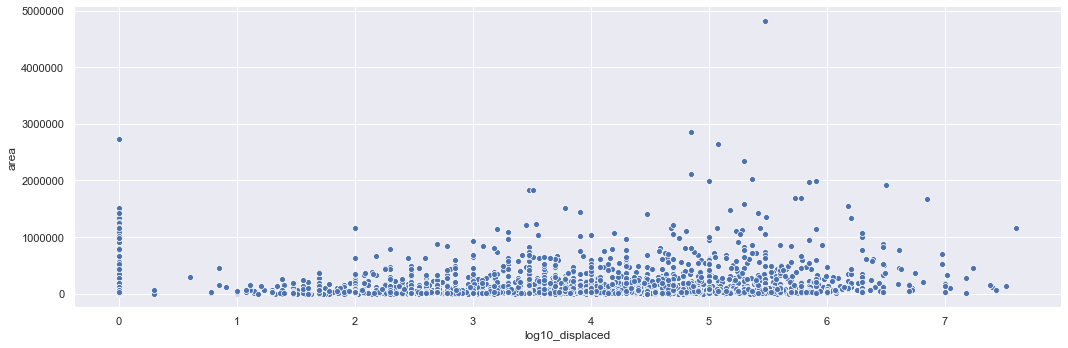

In [24]:
# Correlations in Seaborn
sns.relplot(x='log10_displaced', y='area', data=floods, aspect=3)

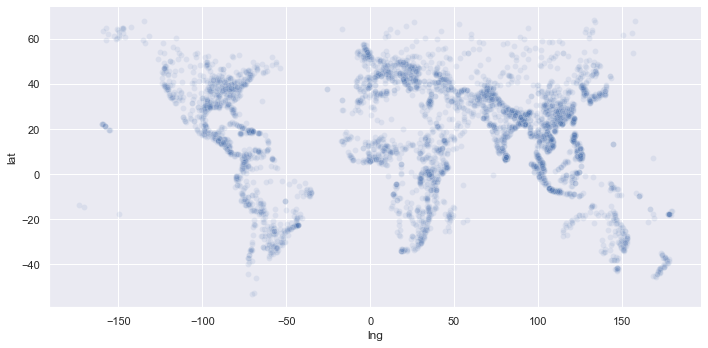

In [25]:
sns.relplot(x='lng', y='lat', alpha=0.1, data=floods, aspect=2)

In [26]:
# Create your own function to recode the data

def recode_cause(cause):
    cause = str(cause).lower()
    if 'monsoon' in cause:
        return 'MONSOON'
    elif 'rain' in cause:
        return 'RAIN'
    elif 'melt' in cause:
        return 'SNOWMELT'
    elif 'tropical storm' in cause:
        return 'TROPICAL STORM'
    else:
        return 'OTHER'


floods['cause_recoded'] = floods['main_cause'].apply(recode_cause)
floods.head()

,id,lng,lat,area,began,ended,validation,dead,displaced,main_cause,severity,log10_displaced,cause_recoded
0,1,5.23026,35.81420,92615.67,1/1/85,1/5/85,News,26,3000,Heavy rain,1.0,3.477121,RAIN
1,2,-45.34890,-18.71110,678498.80,1/15/85,2/2/85,News,229,80000,Heavy rain,2.0,4.903090,RAIN
2,3,122.97400,10.02070,12846.03,1/20/85,1/21/85,News,43,444,Torrential rain,1.0,2.647383,RAIN
3,4,124.60600,1.01489,16542.12,2/4/85,2/18/85,News,21,300,Torrential rain,1.0,2.477121,RAIN
4,5,32.34910,-25.86930,20082.21,2/9/85,2/11/85,News,19,0,Heavy rain,2.0,0.000000,RAIN


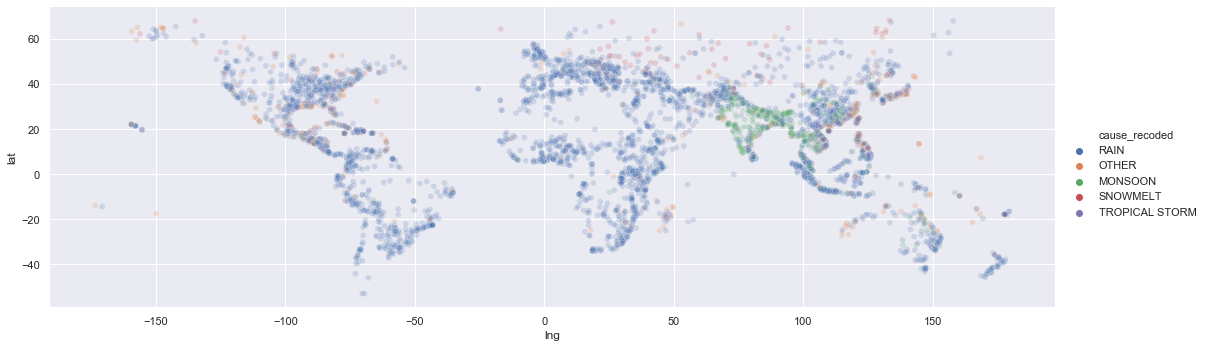

In [27]:
# Show relationship between two variables
sns.relplot(x='lng', y='lat', alpha=0.2, data=floods, hue='cause_recoded', aspect=3)

In [28]:
import pydeck

# Same data on an interactive map
color_lookup = pydeck.data_utils.assign_random_colors(floods['cause_recoded'])
floods['rgb'] = floods['cause_recoded'].apply(lambda x: color_lookup[x])

scatter = pydeck.Layer(
    'ScatterplotLayer',
    data=floods,
    get_position='[lng, lat]',
    get_radius='30000 * severity',
    get_fill_color='rgb',
    pickable=True
)
geojson = pydeck.Layer(
    'GeoJsonLayer',
    data='https://datahub.io/core/geo-countries/r/countries.geojson',
    line_width_min_pixels=1,
    get_radius=10000,
    stroked=True,
    extruded=False,
    filled=True,
    get_line_color=[255, 255, 255, 255]
)
pydeck.Deck(layers=[geojson, scatter], tooltip=True).to_html()

'/Users/duberstein@uber.com/Desktop/uc_davis_workshop/pydeckccntcfdi.html'

### Barcharts

[Text(0, 0.5, 'Log of # of People Displaced'),
 Text(0.5, 0, 'Cause'),
 Text(0.5, 1.0, 'Relative Distributions of Flood Causes')]

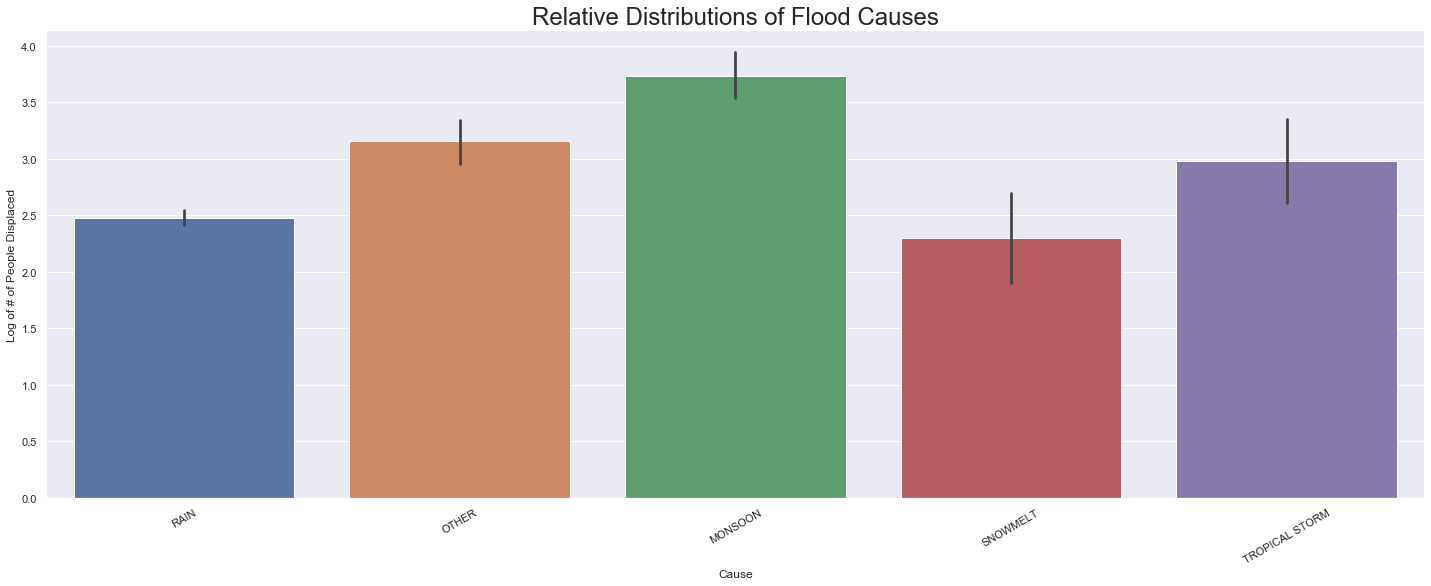

In [30]:
import matplotlib.pyplot as plt

# Relative comparisons
sp = sns.barplot(
    x='cause_recoded',
    y='log10_displaced',
    data=floods)

sns.set(font_scale=2)
sp.set_xticklabels(sp.get_xticklabels(), rotation=30)
sp.set(
    xlabel='Cause',
    ylabel='Log of # of People Displaced',
    title='Relative Distributions of Flood Causes')

In [64]:
# For ease of use, I'll recode a date string
sfo['datetime'] = sfo['Activity Period'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:] + '-01')

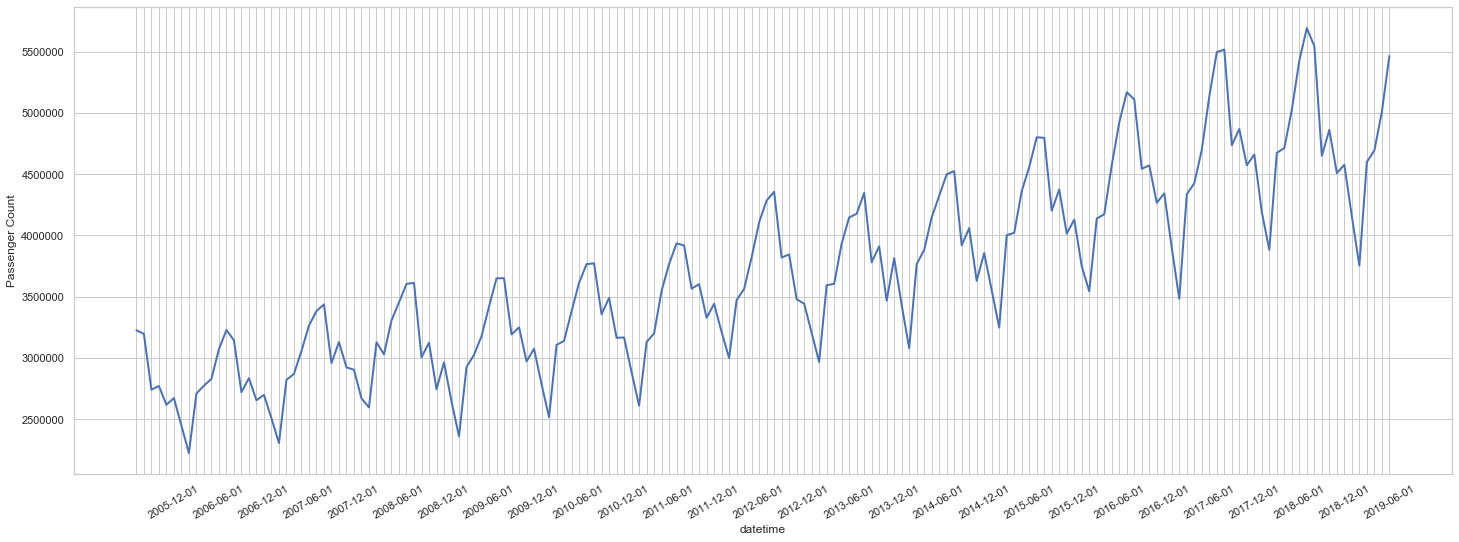

In [32]:
# Time series
sns.set(style="whitegrid")
df = sfo.groupby(['datetime']).sum()['Passenger Count']
df = df.reset_index()
sp = sns.lineplot(
    x='datetime',
    y='Passenger Count',
    data=df,
    linewidth=2)
labels = [x if x.endswith('-12-01') or x.endswith('-06-01') else '' for x in df['datetime']]
sp.set_xticklabels(labels, rotation=30)
sp

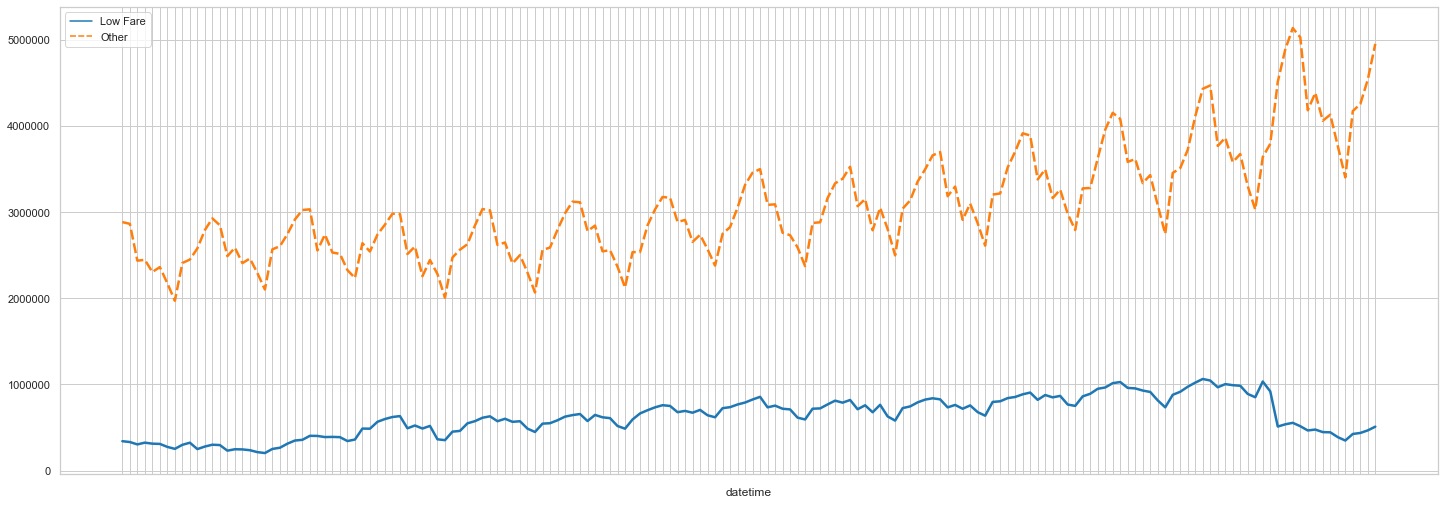

In [33]:
import numpy as np
df = sfo.groupby(['datetime', 'Price Category Code']).sum()['Passenger Count']
df = df.reset_index()
pivoted = pd.pivot_table(
    data=df,
    index='datetime',
    columns='Price Category Code',
    values='Passenger Count',
    aggfunc=np.sum)
c = sns.lineplot(data=pivoted, palette="tab10", hue='Price Category Code', linewidth=2.5)
c.set_xticklabels(c.get_xticklabels(), rotation=30)
c

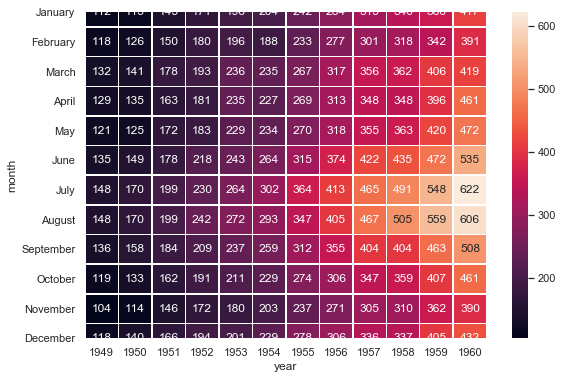

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
# Heatmap from Seaborn docs

# Load the example flights dataset and convert to long-form
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, annot=True, fmt="d", linewidths=.5, ax=ax)

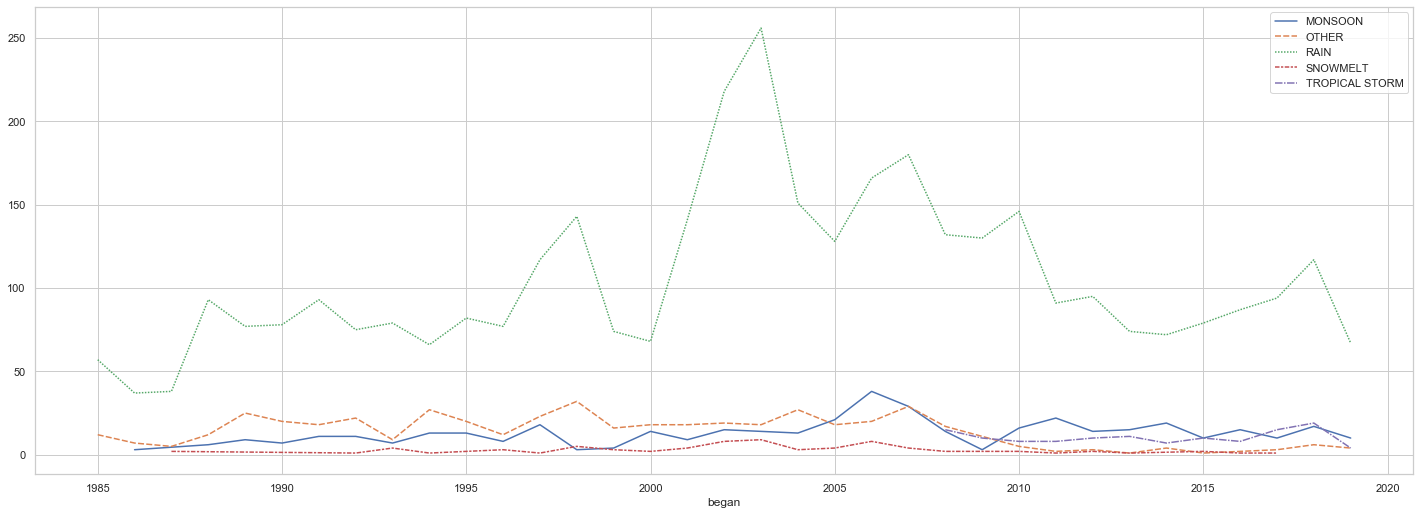

In [45]:
# Subtle errors:

sns.lineplot(data=floods_over_time.set_index('began'))

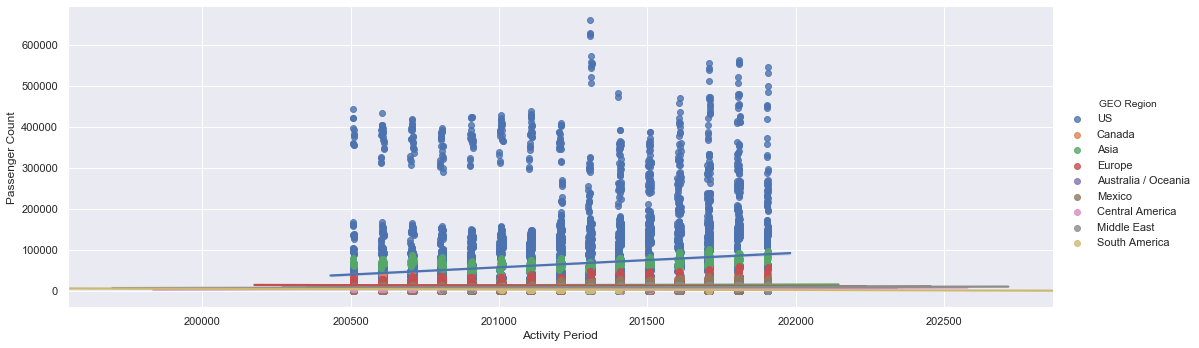

In [87]:
sns.lmplot(
    data=sfo,
    x='Activity Period',
    y='Passenger Count',
    hue='GEO Region',
    aspect=3)

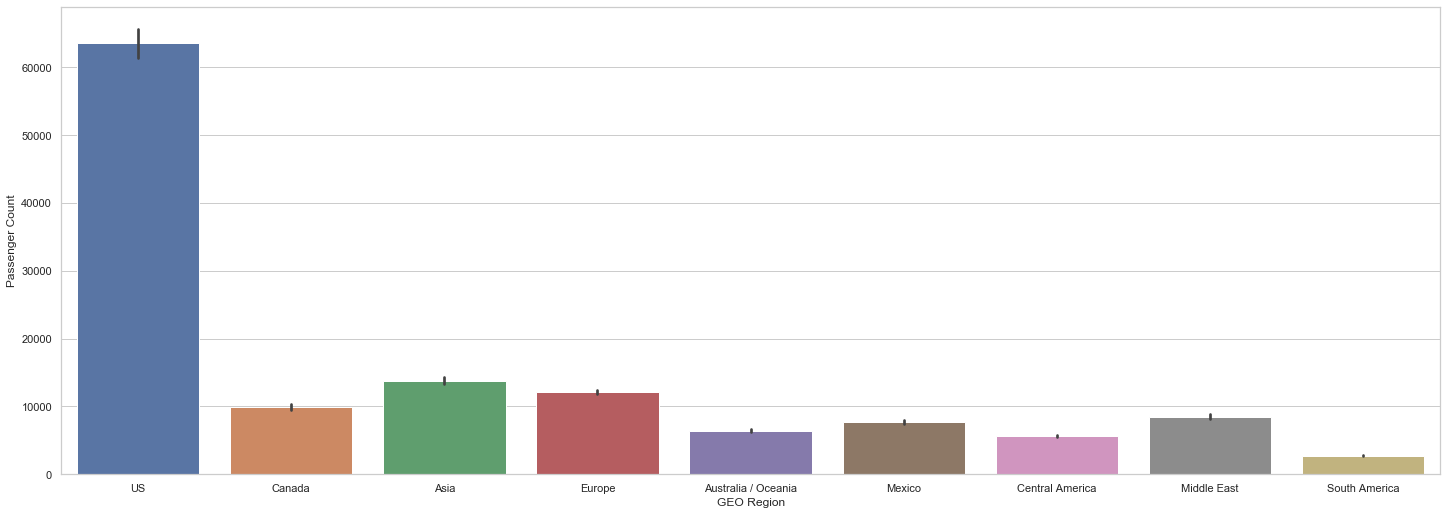

In [57]:
# Your turn